# Etopo with OOP
## Creating a class with a bathymetric map

In this code I use objected-oriented programming to easy-go mapping functions with etopo database

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seawater as sw
import scipy.io as sio
from glob import glob

The class "BaseEtopo" is generated exclusively to work with a .mat file containg bathymetric data

Inside this class, there are some useful tools as "Point" and "Transect" which are used to retrieve informations about the depth of a given point or a list of points, respectively.

In [2]:
def fnear(array, value):
    array = np.asarray(array)
    idx = np.nanargmin((np.abs(array - value)))
    return idx


### Creating my class
class BaseEtopo():
    def __init__(self,filedir):
        self.file = filedir
        self.content = sio.loadmat(self.file)['bat']
        self.batz = self.content[0][0][2]
        self.latz = self.content[0][0][1]
        self.lonz = self.content[0][0][0]
        
    def Transect(self,lon,lat):
        if len(lon) != len(lat) or len(lon)==1:
            print('Transect lat and lon must have the same size and be greater than one single point')
            print('If you are looking for a single point, consider using "Point" object')
        else:
            transect_depth = []
            for x in range(len(lon)):
                iy = fnear(self.lonz,lon[x])
                ix = fnear(self.latz,lat[x])
                transect_depth.append(self.batz[ix,iy])
            return np.array(transect_depth),lon,lat
    
    def Point(self,lon,lat):
        if len(lon) != 1 or len(lat) != 1:
            print('Point object must have only one lat/lon data')
            print('If you are looking for a transect, consider using "Transect" object')
        else:
            iy = fnear(self.lonz,lon)
            ix = fnear(self.latz,lat)
            return self.batz[ix,iy],lon,lat
        
        
    def Adjustgrid(self,long,latg):
        self.lon = long
        self.lat = latg
        
        gradevarx,gradevary = np.meshgrid(self.lon,self.lat)
        
        ilob = np.where((self.lonz >= np.nanmin(self.lon)-1) & (self.lonz <= np.nanmax(self.lon)+1))[0]
        ilab = np.where((self.latz >= np.nanmin(self.lat)-1) & (self.latz <= np.nanmax(self.lat)+1))[0]
        lonb = self.lonz[ilob]
        latb = self.latz[ilab]
        xbat,ybat = np.meshgrid(lonb,latb)
        batg = self.batz[ilab[0]:ilab[-1]+1,ilob[0]:ilob[-1]+1]
        gridedbat = griddata((np.ravel(xbat),np.ravel(ybat)),np.ravel(batg),(np.ravel(gradevarx),np.ravel(gradevary)))
        gridedbat = np.reshape(gridedbat,np.shape(gradevarx))
        self.gridx = gradevarx
        self.gridy = gradevary
        
        return gridedbat
    


In [3]:
#### Importing the data from local directory as a class
Baseb = BaseEtopo('/home/joao/Downloads/etopo2_mundo.mat')

To use the Mapa2D class you must need to create a database class before (Baseb), and with this class you can easily plot and visualize 2D maps of a given variable and also plot the bathymetry on the map.

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


class Mapa2D():
    '''
    This class implements easy-to-go visualization tools for 2D variables (organized as lat x lon)
    using libraries from cartopy. This is just a simple code that helps me to plotting data
    '''
    
    lonz = Baseb.lonz
    latz = Baseb.latz
    Batz = Baseb.batz
    
    def __init__(self,lon,lat,var,color='jet',cloro=False):
        self.lat = lat
        self.lon = lon
        self.cor = color
        if cloro:
            self.var = np.log(var)
        else:
            self.var = var
    
    def ShowMap(self,facecolor='#fecf78',**kwargs):
        fig = kwargs.get('fig')
        ax = kwargs.get('ax')
        if fig and ax:
            ax.add_feature(cfeature.LAND,facecolor=facecolor, edgecolor='k',zorder=99)
        else:
            f = plt.figure(figsize=(8,8))
            ax=f.add_subplot(1, 1, 1,projection=ccrs.PlateCarree(),extent=[np.min(self.lon), np.max(self.lon), np.min(self.lat), np.max(self.lat)])
            ax.add_feature(cfeature.LAND,facecolor=facecolor, edgecolor='k',zorder=99)
        self.ax = ax
        
    def Contourfbat(self,levels=[-2000,-1000,-250,-100]):
        self.ax.contourf(np.squeeze(lonz[::4]),np.squeeze(latz[::4]),Batz[::4,::4],levels=levels,cmap='ocean')

    def Contourbat(self,levels=[-2000,-1000,-250,-100],color='k',width=1):
        self.ax.contour(np.squeeze(lonz[::4]),np.squeeze(latz[::4]),Batz[::4,::4],levels=levels,colors=color,linewidths=width)
        
    def Contourlevel(self,value,color='k',width=2,style='-'):
        self.ax.contour(np.squeeze(lonz[::4]),np.squeeze(latz[::4]),Batz[::4,::4],levels=[-value],colors=color,linewidths=width,linestyles=style,zorder=99)
    
    def Contourflevel(self,value,color='dimgray'):
        self.ax.contourf(np.squeeze(lonz[::4]),np.squeeze(latz[::4]),Batz[::4,::4],levels=[-value,0],colors=color,zorder=99)

    def Contourvar(self,levels=np.arange(-2,2.25,.25)):
        try:
            lv = self.ax.contour(self.lon,self.lat,self.var,levels=levels,colors='k',linewidths=.85)
            self.lv = lv
        except:
            print("An error ocurring during the contour plot, please check your variables, they must have compatible sizes!")
        #return ax
        #if colorbar:
            #plt.colorbar(cv,pad=0.05)
        
    def Contourfvar(self,levels=np.linspace(-2,2,50),colorbar=False):
        try:
            cv = self.ax.contourf(self.lon,self.lat,self.var,levels=levels,extend='both',cmap=self.cor)
            self.cv = cv
        except:
            print("An error ocurring during the contourf plot, please check your variables, they must have compatible sizes!")
        if colorbar:
            plt.colorbar(cv,pad=0.05)
            
    def TransectValue(self,lon,lat):
        print("WARNING: This function considers a 2D Map where x-axis and y-axes are latitude and longitude, respectively")
        if len(lon) != len(lat) or len(lon)==1:
            print('Transect lat and lon must have the same size and be greater than one single point')
            print('If you are looking for a single point, consider using "Point" object')
        else:
            transect_val = []
            for x in range(len(lon)):
                iy = fnear(self.lon,lon[x])
                ix = fnear(self.lat,lat[x])
                transect_val.append(self.var[ix,iy])
            return np.array(transect_val),lon,lat
    
    def PointValue(self,lon,lat):
        print("WARNING: This function considers a 2D Map where x-axis and y-axis are latitude and longitude, respectively")
        if len(lon) != 1 or len(lat) != 1:
            print('Point objects must have only one lat/lon data')
            print('If you are looking for a transect, consider using "Transect Value" object')
        else:
            iy = fnear(self.lon,lon)
            ix = fnear(self.lat,lat)
            return self.var[ix,iy],lon,lat
        
    def PlotPoints(self,lon,lat,color='gray',width=2,size=80):
        if len(lon) != len(lat):
            print('lat and lon must have the same size')
        else:
            if len(lon)==1:
                cor = color
                self.ax.scatter(lon,lat,s=size,edgecolor='k',color=cor)
            else:
                cor = color
                self.ax.plot(lon,lat,linewidth=width,color=cor,marker='.')

    def grid(self,lonv=1,latv=1):
        
        gl = self.ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,
                        color='gray', alpha=0.5, linestyle='--',
                        xlocs=np.arange(-360, 360, lonv),
                        ylocs=np.arange(-90, 90, latv),zorder=99)

        gl.left_labels = True
        gl.right_labels = False
        gl.bottom_labels = True
        gl.top_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        
    def resize(self,lonnew,latnew):
        self.ax.set_xlim([np.min(lonnew),np.max(lonnew)])
        self.ax.set_ylim([np.min(latnew),np.max(latnew)])
        
    def get_axis(self):
        return self.ax
    
    def get_colors(self):
        try:
            if self.cv:
                return self.cv
        except:
            print('No variable from contourf or contour were find, please check it before getting colors')

Whats is the file which I'm currently working on?

In [5]:
Baseb.file

'/home/joao/Downloads/etopo2_mundo.mat'

In [9]:
### Testing the depth of some points
print(Baseb.Point([-40],[-20]))
print(Baseb.Point([-30],[-20]))
print(Baseb.Point([-20],[-20]))

(-33, [-40], [-20])
(-4839, [-30], [-20])
(-5009, [-20], [-20])


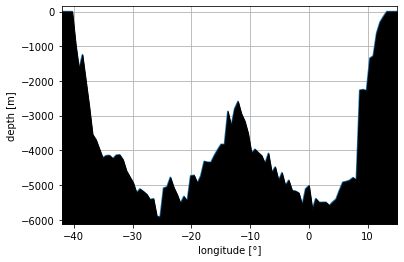

In [41]:
### Creating a zonal transect at 20°S and getting their depth
lonp = np.linspace(-42,15,100)
latp = np.zeros(np.shape(lonp))-20

transect = Baseb.Transect(lonp,latp)

plt.figure(figsize=(6,4))
plt.plot(lonp,transect[0])
plt.fill_between(lonp,np.min(transect[0])-200,transect[0],color='k',zorder=99)
plt.ylabel("depth [m]")
plt.xlabel("longitude [°]")
plt.xlim([lonp[0],lonp[-1]])
plt.ylim([np.min(transect[0])-200,150])
plt.grid()